In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json

from functools import partial
from torch.optim.lr_scheduler import StepLR

import grf.factory as factory
import ex_plots

from graph.belief_network import ArithmeticCircuit
from ex_utils import sample_batch, batch_iterator
from ex_density_estimation import ex as ex_density_estimation
from ex_inference import ex as ex_inference

ValueError: Reference at 'refs/heads/master' does not exist

In [ ]:
device = "cpu" if not(torch.cuda.is_available()) else "cuda:0"

# Residual Flows for Density Estimation \& Amortized Inference in Directed Graphical Models

## Architecture

The flow $F$ consists of $T$ layers where each layer performs the following update to the variables:

$$
\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} + g_t(\mathbf{x}_{t-1}).
$$

The function $g_t(\cdot)$ is a neural network whose weights are masked such that output i, corresponding to random variable $x_i$, is dependent on only those inputs corresponding to $x_i$ and its parents in the associated belief network. Thus, if $g_t(\cdot)$ has only one hidden layer, then:

$$
g(x) = (M_1 \odot W_1) \cdot h((M_0 \odot W_0) \cdot\mathbf{x} + \mathbf{b}_0) + \mathbf{b}_1
$$

Here, $M_0$ and $M_1$ are the masking matrices that enforce the dependency structure. The masking scheme is similar to the approach of [MADE](https://arxiv.org/abs/1502.03509) [1], but allows for arbitrary graph structures instead of just a fully-connected, i.e. autoregressive, structure. The activation function $h(\cdot)$ is any function for which $Lip(h) \le 1$ (where $Lip(\cdot)$ is the Lipschitz constant), e.g. tanh, sigmoid or LipSwish. Furthermore the Lipschitz constant of each weight matrix is constrained, through spectral normalization, to be $< 1$. This makes each residual block $g(\cdot)$ contractive and ensures invertibilit of the flow as a whole [2].

## Computing the Jacobian Determinant

The dependencies in the belief network introduce a topological ordering for the variables. The masked weights, enforcing these dependencies, therefore ensure that variable $x_i$ will only be a function of variables earlier in the topological ordering. It naturally follows that the Jacobian matrix of each of the flow layers will be triangular and can be computed as follows (again assuming a single hidden layer):

$$
J_{f_t}(z) = (M_1 \odot W_1) \cdot diag(h'((M_0 \odot W_0)\cdot\mathbf{z} + \mathbf{b}_0))\cdot (M_0 \odot W_0) + I
$$

Since the Jacobian is triangular, its determinant is easy to compute as the product of its diagonal entries. Thus, one can find the exact solution to the change-of-variable formula.

## Inverting the Flow

Given $\mathbf{y} = f_t(\mathbf{x})$, the flow step can be inverted using the following Newton-like fixed-point iterartive method (for more details see: [here](https://arxiv.org/abs/1907.07945?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%253A+arxiv%252FQSXk+%2528ExcitingAds%2521+cs+updates+on+arXiv.org%2529)) [3]:

$$
\begin{align*}
\mathbf{y}_0 &= \mathbf{x} \\ 
\mathbf{y}_{t+1} &\leftarrow \mathbf{y}_t + diag(J_{f_t}(\mathbf{y}_t))^{-1}[f_t(\mathbf{y}_t) - z].
\end{align*}
$$

## Density Estimation

A common task is to perform density estimation for a new data point $\mathbf{x}$, given some training data. By learning a flow, $F$, that maps a sample from the data distribution to some known base distribution, the density of new data point can be approximated using the change-of-variable formula:

$$
\log p(\mathbf{x}) = \log p_0(F(\mathbf{x})) + \log \left|det(J_F(\mathbf{x}))\right|, \qquad p_0= \mathcal{N}(0,I)
$$

### Example BN: Arithmetic Circuit

The arithmetic belief-network poses a somewhat challenging distribution to estimate:

$$
\begin{align*}
x_0 &\sim \mathcal{L}(5,1) \\
x_1 &\sim \mathcal{L}(-2,1) \\
x_2 &\sim \mathcal{N}(\tanh(z_0+z_1 - 2.8),0.1) \\
x_3 &\sim \mathcal{N}(z_0+z_1,0.1) \\
x_4 &\sim \mathcal{N}(7,2) \\
x_5 &\sim \mathcal{N}(\tanh(z_3+z_4),0.1) \\
x_6 &\sim \mathcal{N}(z_3,0.1) \\
x_7 &\sim \mathcal{N}(z_5,0.1)
\end{align*}
$$

Below, we train a flow on synthetic data generated using the above distributions for each variable. After training, one can generate new data samples by sampling from the base distribution ($\mathcal{N}(0,I)$) and passing this sample through the inverted flow. The training function provides plots of new samples generated in this manner, compared to the real data distribution. The latent representation of each variable learned by the flow, is also visualized using a density plot and should correspond to a standard normal distribution.

In [4]:
# Initialize BN
bn = ArithmeticCircuit()
n = bn.get_num_vertices()

INFO - residual_nf_density_estimation - Running command 'run'
INFO - residual_nf_density_estimation - Started run with ID "1"


[  1]: train nll: 15.30880; test nll: 8.84994 (model), 1.44975 (true)
[  2]: train nll: 8.34440; test nll: 6.70470 (model), 0.87792 (true)
[  3]: train nll: 6.82279; test nll: 6.51174 (model), 1.13507 (true)
[  4]: train nll: 5.20958; test nll: 5.93868 (model), 1.07897 (true)
[  5]: train nll: 4.88113; test nll: 5.10146 (model), 1.16544 (true)
[  6]: train nll: 3.86577; test nll: 4.20594 (model), 0.96337 (true)
[  7]: train nll: 3.93203; test nll: 2.64034 (model), 0.80805 (true)
[  8]: train nll: 3.37918; test nll: 3.52111 (model), 1.38518 (true)
[  9]: train nll: 3.20517; test nll: 2.32645 (model), 0.87260 (true)
[ 10]: train nll: 2.94011; test nll: 5.26332 (model), 1.38498 (true)
[ 11]: train nll: 2.62760; test nll: 2.32484 (model), 1.26697 (true)
[ 12]: train nll: 2.46623; test nll: 2.54132 (model), 0.82900 (true)
[ 13]: train nll: 2.46609; test nll: 3.60882 (model), 1.09385 (true)
[ 14]: train nll: 2.50729; test nll: 3.16508 (model), 1.13112 (true)
[ 15]: train nll: 2.34323; test n

INFO - residual_nf_density_estimation - Completed after 0:07:08


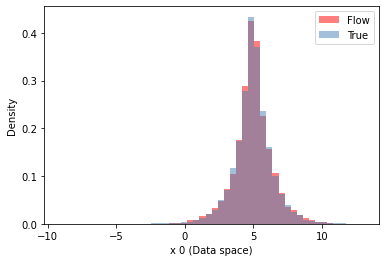

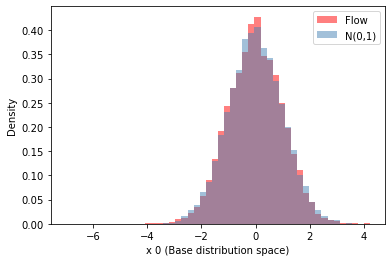

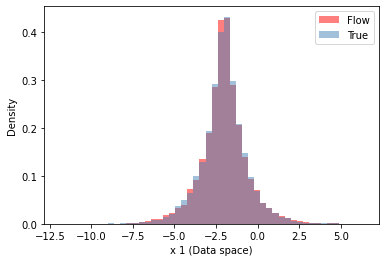

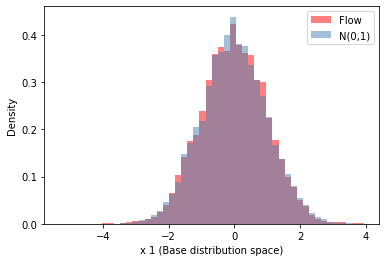

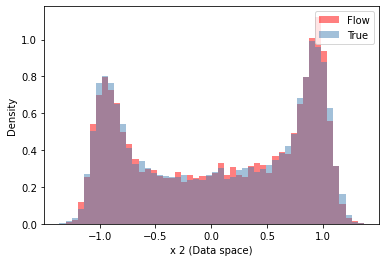

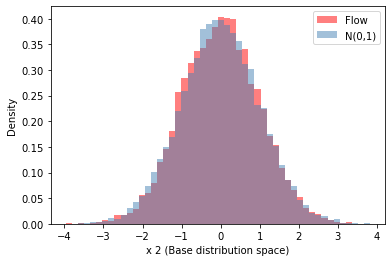

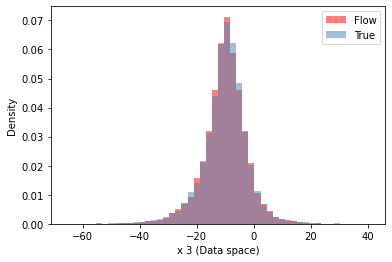

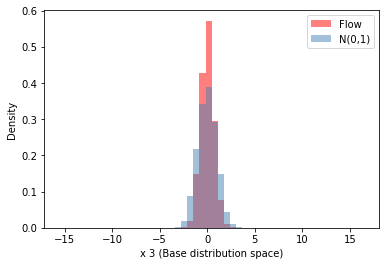

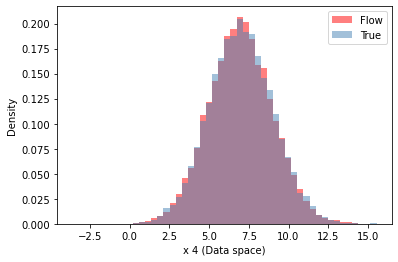

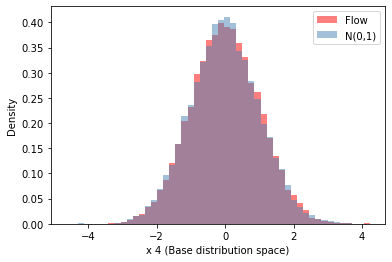

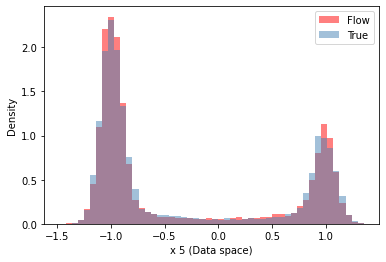

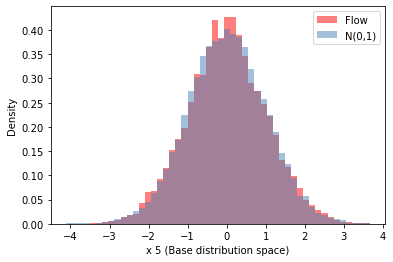

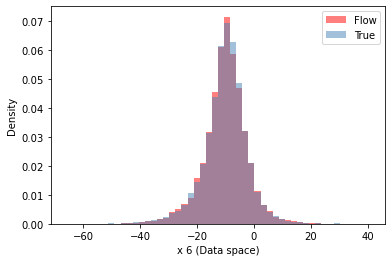

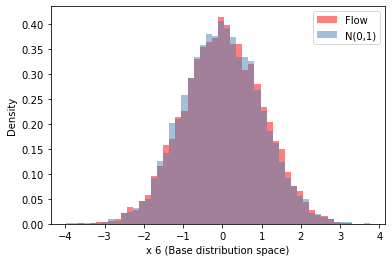

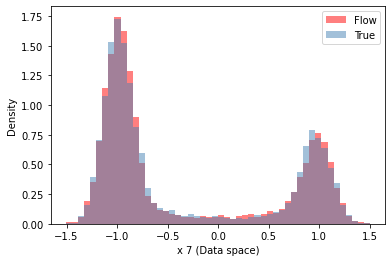

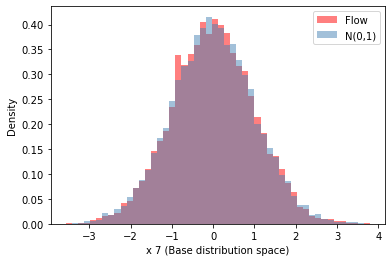

In [5]:
# Train the flow
r = ex_density_estimation.run(config_updates={
        'bn':'arithmetic',
        'batch_size':100,
        'num_blocks':10,
        'hidden_dims':[250]
    })

## Amortized Inference

Another useful task is to infer the state of a set of latent variables, $\mathbf{z}$, given the state of a set of observed variables, $\mathbf{x}$. One approach is to construct a model, $q(\mathbf{z}|\mathbf{x})$, that best approximates the true posterior distribution $p(\mathbf{z}|\mathbf{x})$. This is known as amortized variational inference, since one does not need to rerun the optimization procedure for each new $\mathbf{x}$. Using a flow, $F$, that maps samples from some known base distribution to the latent distribution, one can infer (generate) the latent state for a given observed state and simultaneously calculate the posterior density of the generated latent sample:

$$
q(\mathbf{z}|\mathbf{x}) = p_0(\mathbf{\epsilon}) - \log \left|det(J_F(\mathbf{\epsilon|\mathbf{x}}))\right|, \qquad \epsilon \sim \mathcal{N}(0,I)
$$

Finally, one needs to note that the given belief network usually encodes the 'forward' dependency structure, i.e., the arrows in the DAG point from the latent variables to the observed variables (corresponding to how we believe the data was generated). For inference, where only the leaf nodes are observed, one needs to invert this dependency structure in order to determine dependencies (and independencies) between the variables given that some are observed. For this we employ the inversion algorithm described by [Webb et al.](https://arxiv.org/abs/1712.00287) [4], which returns an inverted BN that is still faithful to the independencies encoded by the original.

In the example below, we again consider the arithmetic circuit BN. Now, we assume $x_0$ to $x_5$ to be latent and only $x_6$ and $x_7$ are observed.

In [5]:
r = ex_inference.run(config_updates={
        'bn':'arithmetic',
        'batch_size':100,
        'num_blocks':30,
        'hidden_dims':[100,100],
        'activation_function':'elu',
        'lr_decay_step_size': 30,
        'seed':34
    })

INFO - residual_nf - Running command 'run'
INFO - residual_nf - Started run with ID "10"


[ ]: Shifted Reverse KL-divergence
[1]: test 14.025551187825144, train 237.01086736978726
[2]: test 11.850884565535255, train 13.645546177892808
[3]: test 9.53982721157333, train 11.107698497849139
[4]: test 10.925208993262537, train 17.56687508474461
[5]: test 7.063517043763138, train 9.269153341604062
[6]: test 17.017120189469274, train 9.22945258902935
[7]: test 15.38663211951174, train 14.756393320979688
[8]: test 7.730871453060839, train 8.92432547200224
[9]: test 6.871721180713832, train 11.112992680998776
[10]: test 6.451127657484863, train 8.146296928385034
[11]: test 14.554154253938464, train 23.472704966563573
[12]: test 7.484633399647366, train 7.777850847596068
[13]: test 7.877163031676115, train 8.004742628966177
[14]: test 6.359090456774334, train 7.939989816501363
[15]: test 6.267029176246703, train 6.837222476294068
[16]: test 5.445427263591397, train 7.7436362335259
[17]: test 6.743631870884992, train 7.012599998773285
[18]: test 6.8146744543514295, train 10.3635625164

INFO - residual_nf - Completed after 1:02:53


[25] [0.9900005328630415, 0.9900000074316625, 0.9900000152159801]
[26] [0.9900000156937583, 0.9900000029394981, 0.9338454577511032]
[27] [0.9900085254245334, 0.9900036329507822, 0.9899999825381285]
[28] [0.990041395471943, 0.9900000242161382, 0.9465823056545298]
[29] [0.9900567114654699, 0.9899999817904553, 0.9900000054359606]


In [6]:
path = './experiment_logs/residual_nf_inference/arithmetic_graphical-lipschitz_99/10/'
model = torch.load(path+'model.pt').to(device)
batch_size = 10000
sample = (sample_batch(bn.sample, batch_size)).double().to(device)
ex_plots.infer(model, bn, sample)

RuntimeError: CUDA out of memory. Tried to allocate 46.00 MiB (GPU 0; 7.79 GiB total capacity; 1.31 GiB already allocated; 41.62 MiB free; 1.34 GiB reserved in total by PyTorch)

## Inversion

It can be shown that the graphical residual flow is bi-lipschitz. This helps to ensure stable invertibility. The following shows the reconstruction error as a function of the number of iterations used to invert each flow step. The fixed-point inversion algorithm converges quickly. 

In [5]:
def inversion_error(model, bn, T, batch_size):
    num_latent = bn.get_num_latent()
    sample = torch.DoubleTensor(sample_batch(bn.sample, batch_size)).to(device)
    x = sample[:,num_latent:]

    iter = [*np.arange(1,T+1)]
    errors = []
    print('[iter] L2 norm')
    print('       ' + 'Res Flow')
    for t in iter:
        # Res Flow
        # Forward pass through F: e0 -> z
        eps0, z, _ = model(x)
        # Inversion F^{-1}: z -> e0'
        eps0_prime, _ = model.inverse(z, x, maxT=t, epsilon=1e-15)
        # Measure error
        err = torch.norm(eps0 - eps0_prime, dim=1).mean().item()
        errors.append(err)


        print(('[{}]'.format(t)).rjust(6) + ' {}'.format(err))

    plt.plot(iter, errors)
    plt.yscale("log")
    plt.xlabel('Number of iterations')
    plt.ylabel('L2 norm')
    xint= []
    skip=False
    for each in iter:
        if not skip:
            xint.append(int(each))
        skip = not skip
    plt.xticks(xint)
    plt.title('Inversion error')
    plt.show()

In [ ]:
path= './experiment_logs/residual_nf_inference/arithmetic_graphical-lipschitz_99/1/model.pt'
flow = torch.load(path).to(device)
inversion_error(flow, bn, T=20, batch_size=100)

## References

[1] Mathieu Germain, Karol Gregor, Iain Murray, and Hugo Larochelle. Made: Masked autoencoder for distribution estimation. In Francis Bach and David Blei, editors, Proceedings of the 32nd International Conference on Machine Learning, volume 37 of Proceedings of Machine Learning Research, pages 881–889, Lille, France, 07–09 Jul 2015. PMLR.

[2] Ricky T. Q. Chen, Jens Behrmann, David Duvenaud, and J ̈orn-Henrik
Jacobsen. Residual flows for invertible generative modeling, 2020.

[3] Yang Song, Chenlin Meng, and Stefano Ermon. Mintnet: Building invertible neural networks with masked convolutions, 2019.

[4] Stefan Webb, Adam Golinski, Robert Zinkov, N. Siddharth, Tom Rain-
forth, Yee Whye Teh, and Frank Wood. Faithful inversion of generative
models for effective amortized inference, 2018.